# Binomial MLE: classical vs. bayesian approach
Author: Dusan Randjelovic, Seven Bridges Genomics, <dusan.randjelovic@sbgenomics.com>  
NOTE: Partially based on http://pages.uoregon.edu/cfulton/posts

#### TL;DR

Bernoulli trial is random experiment with binary outcome:

$$
\text{Bernoulli}(\theta) = 
\begin{cases}
    \theta & x = 1 \\
    1 - \theta & x = 0
\end{cases}
$$

Possible number of succeses (counts) in $n_{trial}$ trials is binomial:

$$
\text{Binomial}(n, \theta) = p(x\ |\ n,\theta) = \binom{n}{x}\cdot\theta^{x}\cdot(1-\theta)^{n-x}
$$

If for some dataset we anticipate binomial distribution we can estimate "best-fit" parameters of binomial by finding global maximum of binomial likelihood function (**MLE method**). This could be done **analytically** or numerically, but methods differ if we take *frequentist* (classical) or *bayesian* approach. Analytical approaches are compared below and it is shown how bayesian approach corresponds to **Expectation-Maximization (EM) algorithm** for MLE.

# Setup and simulation

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats

In [2]:
# Simulate data
np.random.seed(2121)

nobs = 200
ntrials = 20
theta = 0.3

Xber = np.random.binomial(1, theta, nobs) # bernoulli distribution
Xbin = np.random.binomial(ntrials, theta, nobs)

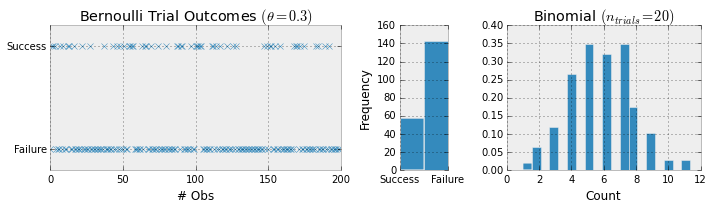

In [40]:
# Plot the data
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1, 3, width_ratios=[6, 1, 4]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

ax1.plot(range(nobs), Xber, 'x')
ax2.hist(-Xber, bins=2)
ax3.hist(Xbin, bins=22, normed=True)

ax1.yaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Success', 'Failure'));

ax1.set(title=r'Bernoulli Trial Outcomes $(\theta=0.3)$', xlabel='# Obs', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')
ax3.set(title=r'Binomial $(n_{trials}=20)$', xlabel='Count', xlim=(0,12), ylim=(0, 0.4))

fig.tight_layout()

#### Likelihood

If $X = (x_1, x_2, \ldots, x_k)$, $k=n_{obs}$, $n=n_{trials}$ and $L(\theta; x_i) =  \binom{n}{x_i}\cdot\theta^{x_i}\cdot(1-\theta)^{n-x_i}$ then:

$$L(\theta; X) = \prod_{i=1}^{k}\binom{n}{x_i}\cdot\theta^{x_i}\cdot(1-\theta)^{n-x_i}$$

## Binomial MLE: classical approach

If instead of likelihood we take log-likelihood, derivation of global maximum is somewhat easier. Logarithm is strictly monotonically increasing function, so:

$$
\underset{\theta}{\mathrm{argmax}}\Big( L(\theta; X\Big) = \underset{\theta}{\mathrm{argmax}}\Big(\log L(\theta; X)\Big)
$$

$$
\log L = \log\Big( \prod_{i=1}^{k}\binom{n}{x_i}\cdot\theta^{x_i}\cdot(1-\theta)^{n-x_i} \Big) = \sum_{i}\Big( \log\binom{n}{x_i}\Big) + \sum_{i}\Big( \log\theta^{x_i} \Big) + \sum_{i}\Big( \log (1-\theta)^{n-x_i}\Big)
$$

For first derivative = 0 and second < 0 and $\theta\neq \{0,1\}$ => local maxima:

$$
\frac{\partial}{\partial{\theta}}\log L = \frac{\partial}{\partial{\theta}}\log\theta\cdot\sum_{i}x_i + \frac{\partial}{\partial{\theta}}\log(1-\theta)\cdot\sum_{i}(n-x_i)
$$

where $\sum_{i}x_i$ is total number of successes and $\sum_{i}(n - x_i) = n_{trials}\cdot n_{obs} - \sum_{i}x_i$ number of failures

For $\frac{\partial\log L}{\partial\theta} = 0$

$$
\frac{\sum_{i}x_i}{\theta} - \frac{n_{trials}\cdot n_{obs} - \sum_{i}x_i}{1-\theta} = 0\\
$$

$$
\boxed{
    \hat{\theta} = \frac{\sum_{i}x_i}{n_{obs}\cdot n_{trials}}
}
$$

MLE of theta (Classical analytical approach): 0.32


/encrypted/opt_dir/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


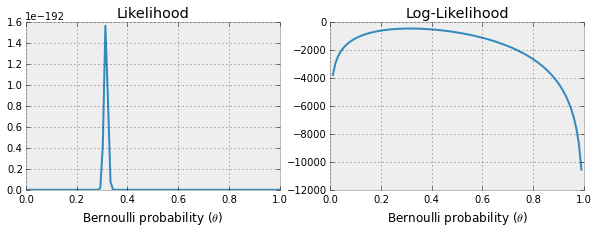

In [3]:
# Example data
np.random.seed(4242)
data = np.random.binomial(ntrials, theta, nobs) 
# data = [5,5,6,6,7]

thetas = np.linspace(0,1,100)
binoms = [np.math.factorial(ntrials)/(np.math.factorial(x)*np.math.factorial(ntrials-x)) for x in data]
points = [[bn * t**x * (1-t)**(ntrials-x) for t in thetas] for bn, x in zip(binoms, data)]
L = [np.prod(x) for x in zip(*points)]
logL = [np.sum(np.log(x)) for x in zip(*points)]

# plots
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(thetas,L)
ax2.plot(thetas,logL)
ax1.set(title='Likelihood', xlabel=r'Bernoulli probability ($\theta$)')
ax2.set(title='Log-Likelihood', xlabel=r'Bernoulli probability ($\theta$)')

print 'MLE of theta (Classical analytical approach): %.2f' % (np.array(data).sum() / (len(data) * ntrials))

## Role of likelihood in bayesian approach

Using Bayes' rule:
$$
p(\theta|X) = \frac{L(\theta;X)\cdot p(\theta)}{p(X)}
$$

To perform Bayesian estimation, we need to construct the posterior given:  
* the (joint) likelihood $L(\theta;X)$
* the prior $p(\theta)$  
* the marginal probability density function $p(X)$  

marginal PDF is constant w.r.t theta, so $p(\theta|X) \sim L(\theta;X)\cdot p(\theta)$

Prior and posterior are usually set to be from same distribution family, so if we expect binomial posterior, it is common to take beta distribution as prior (beta distribution is common prior overall).

With prior $p(\theta;\alpha_1,\alpha_2) = \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1}$, it could be shown that posterior is:

$$
\begin{align}
p(\theta | X; \alpha_1,\alpha_2) & = L(\theta;X) \cdot P(\theta) \\
& = \prod_{i=1}^{k}\binom{n}{x_i}\cdot\theta^{x_i}\cdot(1-\theta)^{n-x_i} \cdot  \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1}\\
& \propto \theta^{\sum_{i}x_i + \alpha_1-1} (1 - \theta)^{n_{trials}\cdot n_{obs} - \sum_{i}x_i + \alpha_2 - 1} \\
\end{align}
$$

Posterior Mean (Analytic): 0.315


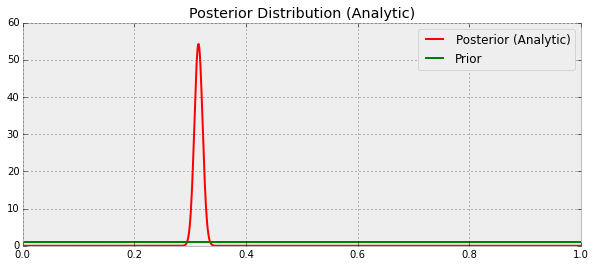

In [38]:
# For alpha_1 = alpha_2 = 1, the Beta distribution
# degenerates to a uniform distribution
a1 = 1
a2 = 1

# Find the hyperparameters of the posterior
a1_hat = a1 + data.sum() - 1
a2_hat = a2 + ntrials * nobs - data.sum() - 1

# Posterior Mean
post_mean = a1_hat / (a1_hat + a2_hat)
print 'Posterior Mean (Analytic):', post_mean

# Plot the analytic posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');

# Plot the prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');

# Cleanup
ax.set(title='Posterior Distribution (Analytic)', ylim=(0,60))
ax.legend(['Posterior (Analytic)', 'Prior']);